# 01_DetectOpening_fromSIC

---

02/06/2024

Find daily sea ice opening area in the SBS region from the MODIS-AMSR2 SIC data product.

Reference:<br>
Ludwig, V., G. Spreen, & L. T. Pedersen (2020). Evaluation of a New Merged Sea-Ice Concentration Dataset at 1 km Resolution from Thermal Infrared and Passive Microwave Satellite Data in the Arctic. Remote Sens.  12(19), 3183. https://doi.org/10.3390/rs12193183

URL for data access:<br>
https://seaice.uni-bremen.de/sea-ice-concentration/modis-amsr2/

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

from common_imports import *

### Create polygons

In [2]:
poly_mask_dict = {}

# 10m isobath
poly_mask_dict['R2'] = {}
poly_mask_dict['R2']['lon_corners']  = np.array([203.3, 203.5, 203.6, 203.75, 204, 204.8, 205, 205.8, 206, 206.5, 207, 207.5, 208,
                208.35, 208.55, 208.7, 209, 209.4, 209.45, 210, 210.6, 210.675, 210.775, 
                210.85, 211, 211.4, 211.6, 211.8, 212, 212.175, 212.3, 212.5, 213, 213.3, 213.6, 214,
                214.5, 215, 215.225, 215.5, 215.75, 216, 216.35, 216.7, 217, 217.4,
                217.5, 217.8, 218, 218.2, 218.525, 218.8, 218.9, 219, 219.2, 219.25, 
                220, 220.25, 220.5, 220.6, 220.7, 220.8, 220.9, 221, 221.15, 221.1, 221,
                221.05, 221.15, 221.3,221.45, 221.5, 221.55, 221.625, 221.755, 222, 222.3, 
                222.375, 222.67, 223, 223.15, 223.25, 223.475, 223.575, 223.75, 223.875, 224.05, 
                224.375, 225, 225.3, 226.075, 226.5, 226.7, 227, 227.3, 227.55, 227.85, 
                228.025, 228.1, 228.2, 228.25, 228.4, 228.6, 228.725, 228.85, 229, 229.085,  
                229.6, 229.65, 229.725, 229.8, 229.95, 230.35, 230.43, 230.575, 230.85, 231.05,
                231.05, 230.9, 230.8, 230.55, 230.65, 230.85, 230.875, 231, 231.4, 231.35, 231.5, 231.625, 231.625, 231.55, 231.6, 231.5, 231.525, 231.625, 
                231.6475, 231.75, 231.925, 232, 232.1, 232.3, 232.6, 232.8, 233, 233, 224, 203, 203.3])
poly_mask_dict['R2']['lat_corners'] = np.array([71.35, 71.41, 71.42, 71.385, 71.35, 71.23, 71.19, 71.01, 71, 71, 70.99, 70.95, 70.88,
                70.8, 70.7, 70.66, 70.625, 70.62, 70.6, 70.6, 70.58, 70.62, 70.63, 
                70.6, 70.55, 70.5, 70.515, 70.55, 70.55, 70.52, 70.45, 70.4, 70.33, 70.27, 70.24, 70.22,
                70.1, 70.06, 70.02, 70.05, 70.1, 70.13, 70.17, 70.16, 70.11, 70.04,
                70, 69.9, 69.85, 69.83, 69.7435, 69.72, 69.68, 69.68, 69.655, 69.635, 
                69.63, 69.62, 69.575, 69.59, 69.625, 69.655, 69.68, 69.65, 69.6, 69.56, 69.5,
                69.43, 69.4, 69.355, 69.4, 69.395, 69.34, 69.33, 69.2, 69.13, 69.06, 
                69.06, 69.2, 69.37, 69.45, 69.47, 69.5825, 69.6, 69.69, 69.69, 69.75,
                69.75, 69.83, 69.875, 69.885, 69.8, 69.78, 69.85, 69.89, 69.84, 69.895,
                69.91, 69.88, 69.88, 69.915, 69.9375, 70, 70.045, 70.05, 70.12, 70.2, 
                70.3, 70.34, 70.34, 70.3, 70.29, 70.33, 70.38, 70.38, 70.3, 70.25,
                70.175, 70.145, 70.04, 69.915, 69.895, 69.91, 69.97, 70, 70, 70.08, 70.2, 70.25, 70.37, 70.42, 70.46, 70.5, 70.55, 70.575, 
                70.625, 70.67, 70.66, 70.635, 70.565, 70.505, 70.4, 70.3, 70.15, 69., 68.25, 70.5,71.35])

# Herschel Island LF ice
poly_mask_dict['R1'] = {}
poly_mask_dict['R1']['lon_corners'] = np.array([221, 221.2, 221.6, 222, 222.3, 222.6, 222.8, 222.875, 223.05, 223.5, 223.5, 221, 221 ])
poly_mask_dict['R1']['lat_corners'] = np.array([69.646, 69.6, 69.5, 69.43, 69.4, 69.4, 69.425, 69.49, 69.52, 69.57, 69, 69, 69.646 ])

# add polyogn info to dictionary
#-------------------------------
for poly in poly_mask_dict.keys():

    # shift lons to [-180,180]
    poly_lons = poly_mask_dict[poly]['lon_corners']
    poly_lons[poly_lons>180]-=360
    poly_mask_dict[poly]['lon_corners'] = poly_lons
    
    # grab corners and start arrays to save new points
    org_lons = poly_mask_dict[poly]['lon_corners']
    org_lats = poly_mask_dict[poly]['lat_corners']
    new_lons = np.array([])
    new_lats = np.array([])

    # use shapely to add more points along lines between corners
    #-----------------------------------------------------------
    # number of points along each segment, including endpoints
    n = 10
    for ii in range(len(org_lons)):
        # for last point, wrap around to first point
        if ii == len(org_lons)-1:
            lon_f, lat_f = org_lons[0], org_lats[0]
        else:
            lon_f, lat_f = org_lons[ii+1], org_lats[ii+1]
        # interpolate points along line to create new line with n points
        new_lons_seg, new_lats_seg = add_points_to_segment(lon_i = org_lons[ii], lat_i = org_lats[ii], 
                                                           lon_f = lon_f, lat_f = lat_f, n = n)
        # save segment to full lon/lat list (ignore last point so it's not double counted)
        new_lons = np.append(new_lons, new_lons_seg[:-1])
        new_lats = np.append(new_lats, new_lats_seg[:-1])

    poly_mask_dict[poly]['lon'] = new_lons
    poly_mask_dict[poly]['lat'] = new_lats
    
    # make polygon and add to dict
    polygon = make_polygon(np.stack([poly_mask_dict[poly]['lon'], poly_mask_dict[poly]['lat']], axis=1))
    poly_mask_dict[poly]['polygon'] = polygon

    
poly_dict = {}

# V7
# poly_dict['coast'] = {}
# poly_dict['coast']['lon_corners'] = np.array([205,  218, 232, 232, 223,  205])
# poly_dict['coast']['lat_corners'] = np.array([73.25,  72, 70.6, 70,  69,  71])
# poly_dict['coast'] = {}
# poly_dict['coast']['lon_corners'] = np.array([205,  218, 232, 232, 223,  205])
# poly_dict['coast']['lat_corners'] = np.array([73.5,  72.25, 70.6, 70,  69,  71])
poly_dict['coast'] = {}
poly_dict['coast']['lon_corners'] = np.array([203.5,  218, 232, 232, 223,  203.5])
poly_dict['coast']['lat_corners'] = np.array([73.75,  72.3, 70.6, 70,  69,  71])

# add polyogn info to dictionary
#-------------------------------
for poly in poly_dict.keys():

    # shift lons to [-180,180]
    poly_lons = poly_dict[poly]['lon_corners']
    poly_lons[poly_lons>180]-=360
    poly_dict[poly]['lon_corners'] = poly_lons
    
    # grab corners and start arrays to save new points
    org_lons = poly_dict[poly]['lon_corners']
    org_lats = poly_dict[poly]['lat_corners']

    new_lons = np.array([])
    new_lats = np.array([])

    # use shapely to add more points along lines between corners
    #-----------------------------------------------------------
    # number of points along each segment, including endpoints
    n = 10
    for ii in range(len(org_lons)):
        # for last point, wrap around to first point
        if ii == len(org_lons)-1:
            lon_f, lat_f = org_lons[0], org_lats[0]
        else:
            lon_f, lat_f = org_lons[ii+1], org_lats[ii+1]
        # interpolate points along line to create new line with n points
        new_lons_seg, new_lats_seg = add_points_to_segment(lon_i = org_lons[ii], lat_i = org_lats[ii], 
                                                           lon_f = lon_f, lat_f = lat_f, n = n)
        # save segment to full lon/lat list (ignore last point so it's not double counted)
        new_lons = np.append(new_lons, new_lons_seg[:-1])
        new_lats = np.append(new_lats, new_lats_seg[:-1])

    poly_dict[poly]['lon'] = new_lons
    poly_dict[poly]['lat'] = new_lats
    
    # make polygon and add to dict
    polygon = make_polygon(np.stack([poly_dict[poly]['lon'], poly_dict[poly]['lat']], axis=1))
    poly_dict[poly]['polygon'] = polygon
    

Geodesic coastal polygon area: 230708.247 km^2


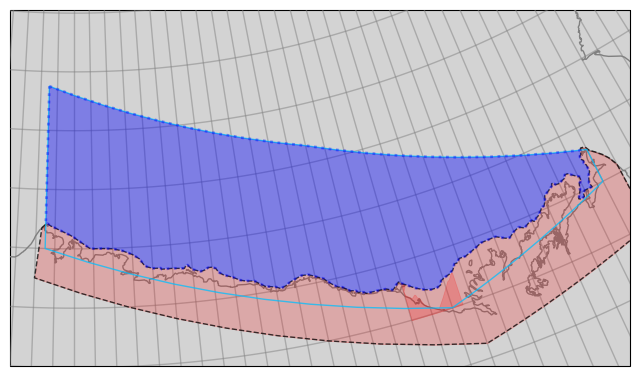

In [3]:
# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,73.25], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')
add_coast(ax, scale='10m', color='gray', linewidth=1, alpha=1, zorder=5)
add_grid(ax, lats=np.arange(65,90,1), lons=np.arange(120,300,1), linewidth=1, color='gray', alpha=0.5, zorder=6)
    
    
# merge regional mask polygons to subtract from main coast polygon 
#-----------------------------------------------------------------
merged_mask = poly_mask_dict['R2']['polygon'].union(poly_mask_dict['R1']['polygon'])
merged_mask
masked_coast_polygon = poly_dict['coast']['polygon'].difference(merged_mask)

# plot the polygons
#------------------
ax.add_geometries([poly_mask_dict['R2']['polygon']], edgecolor='red', linestyle='solid', facecolor='red', lw=0.5, alpha=0.2, crs= ccrs.PlateCarree(), zorder=10)
ax.add_geometries([poly_mask_dict['R1']['polygon']], edgecolor='red', linestyle='solid', facecolor='red', lw=0.5, alpha=0.2, crs= ccrs.PlateCarree(), zorder=10)
  
ax.add_geometries([merged_mask], edgecolor='k', linestyle='dashed', facecolor='None',
                  alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)

ax.add_geometries([poly_dict['coast']['polygon']], edgecolor='deepskyblue', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)
ax.add_geometries([masked_coast_polygon], edgecolor='blue', linestyle='dotted', facecolor='blue',alpha=0.4, lw=2, crs= ccrs.PlateCarree(), zorder=10)

area = abs(geod.geometry_area_perimeter(masked_coast_polygon)[0])
print(f'Geodesic coastal polygon area: {area/(1000*1000):.3f} km^2')
    

In [4]:
# open elevation data
ds_elv = xr.open_dataset('/Volumes/Jewell_EasyStore/AcrticBathymetry_IBCAO_2022/gebco_2022_n90.0_s60.0_w0.0_e360.0.nc')
ds_elv.close()
ds_lon, ds_lat = np.meshgrid(ds_elv.lon.values, ds_elv.lat.values)
elevat = ds_elv.elevation.values


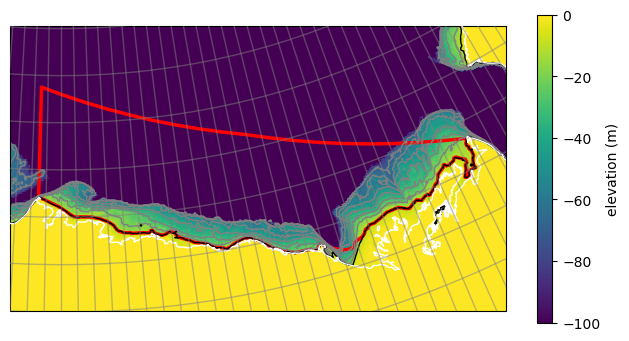

In [5]:
# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,73.25], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')
add_coast(ax, scale='10m', color='white', linewidth=1, alpha=1, zorder=5)
add_grid(ax, lats=np.arange(65,90,1), lons=np.arange(120,300,1), linewidth=1, color='gray', alpha=0.5, zorder=6)
    
    
# plot the polygons
#------------------
ax.add_geometries([masked_coast_polygon], edgecolor='r', linestyle='solid', facecolor='None',alpha=1,lw=2.5, crs= ccrs.PlateCarree(), zorder=1)

# bathymetry contours
sp = 10
el = ax.pcolormesh(ds_lon[::sp, ::sp], ds_lat[::sp, ::sp], elevat[::sp, ::sp], 
              cmap='viridis', vmin=-100, vmax=0, transform=ccrs.PlateCarree(), zorder=0)
fig.colorbar(el, label='elevation (m)', shrink=0.5)
ax.contour(ds_lon[::sp, ::sp], ds_lat[::sp, ::sp], ma.masked_where(ds_lat[::sp, ::sp]<69, 
                                                   ma.masked_where(ds_lon[::sp, ::sp]>240, 
                                                   ma.masked_where(ds_lon[::sp, ::sp]<200, elevat[::sp, ::sp]))), 
           linewidths=1,colors=['gray','gray','gray','gray','gray','gray', 'black'], 
           levels= [-70, -60, -50,-40,-30, -20, -10], transform=ccrs.PlateCarree(), zorder=2)
  


## Save SBS coast polygon to file

In [6]:
# OUTPUT_FILE = './data/coast_mask_regions.nc'


# ds = xr.Dataset(
#         data_vars=dict(
#             R2_lon=(poly_mask_dict['R2']['lon']),
#             R2_lat=(poly_mask_dict['R2']['lat']),
#             R2_poly_str=(str(poly_mask_dict['R2']['polygon'])),
#             R1_lon=(poly_mask_dict['R1']['lon']),
#             R1_lat=(poly_mask_dict['R1']['lat']),
#             R1_poly_str=(str(poly_mask_dict['R1']['polygon'])),   
#             coast_poly_lon=(poly_dict['coast']['lon']),
#             coast_poly_lat=(poly_dict['coast']['lat']),
#             coast_poly_str=(str(poly_dict['coast']['polygon'])),
#             coast_poly_masked_str=(str(masked_coast_polygon)),   
#         ),
#         attrs=dict(description="masked region polygons"),
#     )

# ds


# ds.to_netcdf(path=OUTPUT_FILE, 
#              mode='w', format="NETCDF4")    

## Plot example day SIC data

/opt/anaconda3/envs/geoenvOSU/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


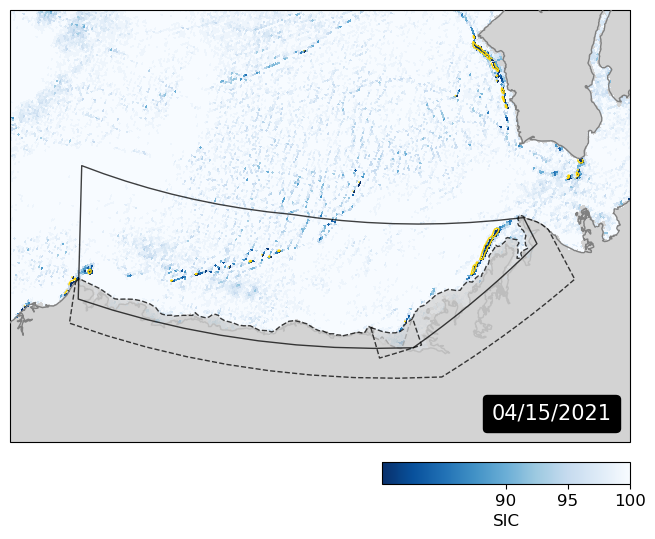

In [7]:


date = datetime(year = 2021, month = 4, day = 15)


# open SIC data
#--------------
out = grab_SIC_MODISAMSR(date=date, file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/SIC_MODIS_AMSR2/', 
                         file_name=f'{date.year}'+'/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                         geo_file='coordinates_npstere_1km_arctic.nc', return_vars=['lon', 'lat', 'sic_merged', 'xx', 'yy', 'proj'])
lon, lat, sic_merge, xx, yy, ice_projection = out[0], out[1], out[2], out[3], out[4], out[5]

sp = 5
SIC_merge = sic_merge[::sp,::sp]
LON, LAT = lon[::sp, ::sp], lat[::sp, ::sp]
XX, YY = xx[::sp,::sp], yy[::sp,::sp]

# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([200,235,68,75], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')
add_coast(ax, scale='10m', color='gray', linewidth=1, alpha=1, zorder=3)
add_date(fig, ax, f'{date.strftime("%m")}/{date.strftime("%d")}/{date.year}', 
         method='anchor', boxstyle='round,pad=0.,rounding_size=0.2', 
         facecolor='black', edgecolor='black', zorder=10, anchor_loc=4, 
         anchor_prop={'size': 15, 'color': 'white'})

# plot SIC
#---------
SIC_mesh = ax.pcolormesh(LON, LAT, ma.masked_where(SIC_merge>100, SIC_merge), 
              cmap='Blues_r', vmin=80, vmax=100, transform=ccrs.PlateCarree(), zorder=2)
ax.contour(XX, YY, ma.masked_where(SIC_merge>100, SIC_merge), 
           levels=[80], linewidths = 1, colors='gold', transform=ice_projection, zorder=5)

# plot the polygons
#------------------
for poly in poly_mask_dict.keys():    
    ax.add_geometries([poly_mask_dict[poly]['polygon']], edgecolor='k', linestyle='dashed', facecolor='lightgray',alpha=0.75, crs= ccrs.PlateCarree(), zorder=11)


ax.add_geometries([poly_dict['coast']['polygon']], edgecolor='k', linestyle='solid', facecolor='none',alpha=0.75, crs= ccrs.PlateCarree(), zorder=11)


add_colorbar(fig, ax, [SIC_mesh], cb_placement='bottom', cb_orientation='horizontal', cb_width='auto', 
         cb_length_fraction=[0.6, 1], cb_pad=0.025, cb_ticks=[90,95,100],
         cb_label='SIC', labelpad='auto', cb_label_placement='auto')

#     fig.savefig(main_path+f"images/SIC_AmsrModis_SIDEx_{year}{monthday}.png",
#                     bbox_inches="tight", pad_inches = 0, dpi=300)

#     plt.close(fig)

plt.show()



## Crop considered SIC data for final bulk run

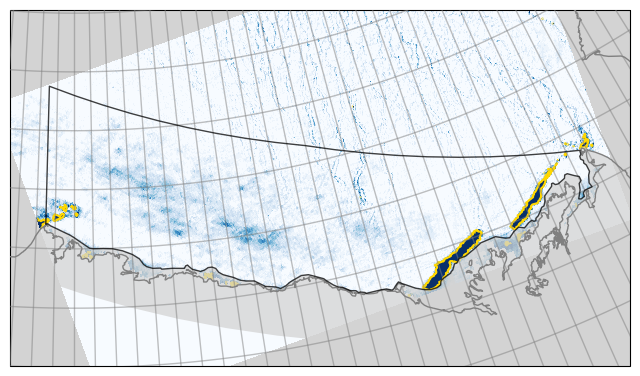

In [8]:
# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,73.25], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')


date = datetime(year = 2021, month = 3, day = 30)

# open SIC data
#--------------
out = grab_SIC_MODISAMSR(date=date, 
                         file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/SIC_MODIS_AMSR2/', 
                         file_name=f'{date.year}'+'/sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                         geo_file='coordinates_npstere_1km_arctic.nc', 
                         return_vars=['lon', 'lat', 'sic_merged', 'unc_sic_merged'])
lon_sic, lat_sic, sic_sic, sic_unc = out[0], out[1], out[2], out[3]

# whole coast, narrow
ai = 2200 # right edge
af = -1500
bi = 400
bf = -4550 # top edge
lon_sic_c = lon_sic[ai:af, bi:bf]
lat_sic_c = lat_sic[ai:af, bi:bf]
sic_sic_c = sic_sic[ai:af, bi:bf]
sic_unc_c = sic_unc[ai:af, bi:bf]

SIC_mesh = ax.pcolormesh(lon_sic_c, lat_sic_c, sic_sic_c, cmap='Blues_r', vmin=80, vmax=100, transform=ccrs.PlateCarree(), zorder=2)
ax.contour(lon_sic_c, lat_sic_c, sic_sic_c, 
           levels=[80], colors=['gold'], transform=ccrs.PlateCarree(), zorder=2)

add_coast(ax, scale='10m', color='gray', linewidth=1, alpha=1, zorder=5)
add_grid(ax, lats=np.arange(65,90,1), lons=np.arange(120,300,1), linewidth=1, color='gray', alpha=0.5, zorder=6)


# plot the polygons
#------------------
ax.add_geometries([masked_coast_polygon], edgecolor='k', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)

    
# plot the polygons
#------------------
for poly in poly_mask_dict.keys():    
    ax.add_geometries([poly_mask_dict[poly]['polygon']], edgecolor='none', linestyle='dashed', facecolor='lightgray',
                      alpha=0.75, crs= ccrs.PlateCarree(), zorder=4)



## Find indices of SIC data within SBS polygon

remove 0.32% of polygon points which are masked as land in the SIC data


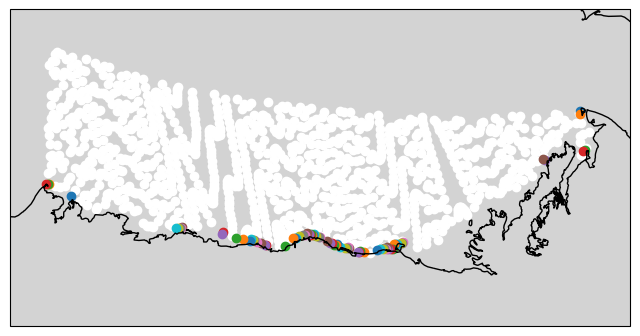

In [9]:
# below is the time-intensive portion!
#-------------------------------------

# add within-polygon indicies of lat/lon coords to dict
poly_indices = within_polygon_indices(masked_coast_polygon, lat_sic_c, lon_sic_c, quiet=True)

# remove indices masked as land (SIC=127)
#----------------------------------------
pp_remove = np.array([])
pp_keep = np.array([])

# remove land mask values (sic=127) to save time when runnning later
for pp in range(len(poly_indices)):
    ii = int(poly_indices[pp][0])
    jj = int(poly_indices[pp][1])
    if sic_sic_c[ii,jj] == 127:
        pp_remove = np.append(pp_remove, poly_indices[pp])
    else:
        pp_keep = np.append(pp_keep, poly_indices[pp])
        
pp_keep = np.reshape(pp_keep.astype(int), (int(len(pp_keep)/2), 2))
pp_remove = np.reshape(pp_remove.astype(int), (int(len(pp_remove)/2), 2))    
print(f'remove {100*len(pp_remove)/len(poly_indices):.2f}% of polygon points which are masked as land in the SIC data')

# create figure
#--------------
map_proj = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,8))
ax.set_extent([202,232,69,72.5], crs=ccrs.PlateCarree());
ax.set_facecolor('lightgray')

for pp in range(len(pp_keep))[::200]:
    ii = int(pp_keep[pp][0])
    jj = int(pp_keep[pp][1])
    ax.scatter(lon_sic_c[ii,jj], lat_sic_c[ii,jj], c='white', transform=ccrs.PlateCarree())
    
for pp in range(len(pp_remove))[::10]:
    ii = int(pp_remove[pp][0])
    jj = int(pp_remove[pp][1])
    ax.scatter(lon_sic_c[ii,jj], lat_sic_c[ii,jj], transform=ccrs.PlateCarree())

ax.coastlines()

poly_pack_indices = pp_keep

### find all the sic values (and uncertainties) in the polygon for given day

In [10]:
# find all values of sic within polygon
all_poly_sic = np.array([])
all_poly_unc = np.array([])

for pp in range(len(poly_pack_indices)):
    
    ii = int(poly_pack_indices[pp][0])
    jj = int(poly_pack_indices[pp][1])
    
    all_poly_sic = np.append(all_poly_sic, sic_sic_c[ii,jj])
    all_poly_unc = np.append(all_poly_unc, sic_unc_c[ii,jj])

print(date)

2021-03-30 00:00:00


### plot

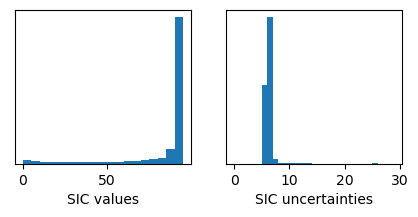

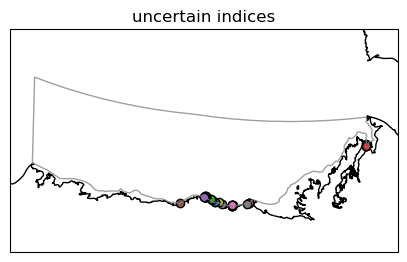

Text(0.5, 0, 'Open water concentrations')

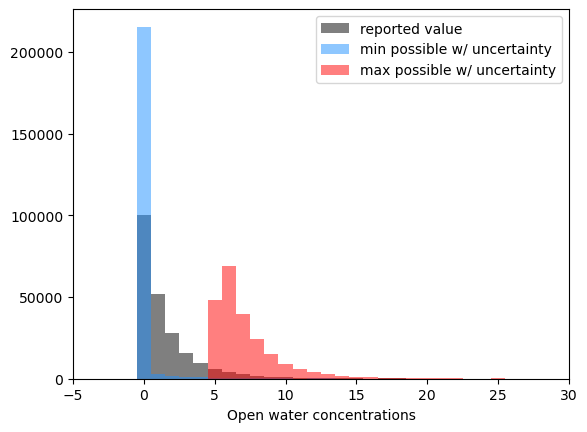

In [11]:
fig, axs = plt.subplots(1,2, figsize=(5,2))
axs[0].hist(all_poly_sic, bins=np.arange(0,100,5))
axs[0].set_yticks([])
axs[0].set_xlabel('SIC values')
axs[1].hist(all_poly_unc, bins=np.arange(0,30,1))
axs[1].set_yticks([])
axs[1].set_xlabel('SIC uncertainties')
# approximate area of open water 
# taking SIC <= 80 as open 
# and using NSIDC 1 km stereo grid as approx 1 km per pixel
# open_area = np.sum(all_poly_sic <= 80) # sq. km


#///////////////
# uncertainty
#//////////////
# all pp index values where uncertainty is high
uncertain_indices = np.where(np.logical_or((all_poly_unc > 100),(all_poly_sic > 100))==True)[0]
certain_indices = np.where(np.logical_and((all_poly_unc <= 100), (all_poly_sic <= 100)))[0]
    
# plot
#-----
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=205)), figsize=(5,3))
ax.set_extent([202,232,69,73.25], crs=ccrs.PlateCarree());
ax.coastlines()
ax.add_geometries([masked_coast_polygon], edgecolor='gray', linestyle='solid', facecolor='None',alpha=0.75, crs= ccrs.PlateCarree(), zorder=10)
for pp in uncertain_indices:
    ii, jj = int(poly_pack_indices[pp][0]), int(poly_pack_indices[pp][1])
    ax.scatter(lon_sic_c[ii, jj], lat_sic_c[ii, jj], edgecolor='k',  transform=ccrs.PlateCarree())
ax.set_title('uncertain indices')
plt.show()


# open water concentration (0-100)
# fill values of sic = 101 will be negative. Neglect these
owc = 100 - all_poly_sic

# find values from estimated uncertainty range
owc_min = 100 - (all_poly_sic+all_poly_unc)
owc_max = 100 - (all_poly_sic-all_poly_unc)

# crop to physical ranges
owc_min[owc_min<0] = 0
owc_max[owc_max>100] = 100

plt.hist(owc, bins=np.arange(-10.5,30.5,1), color = 'black', alpha=0.5,label='reported value')
plt.hist(owc_min, bins=np.arange(-10.5,30.5,1), color = 'dodgerblue',alpha=0.5, label='min possible w/ uncertainty')
plt.hist(owc_max, bins=np.arange(-10.5,30.5,1), color = 'red', alpha=0.5,label='max possible w/ uncertainty')
plt.xlim(-5,30)
plt.legend()
plt.xlabel('Open water concentrations')


# Run over all of 2020-2021 growth season

In [12]:
dates = np.array([])

doa = np.array([])
oa = np.array([])
N_abv10 = np.array([])
oa_abv10 = np.array([])
N_abv20 = np.array([])
oa_abv20 = np.array([])

oa_inc20 = np.array([])
opinga_inc = np.array([])
opinga_inc05 = np.array([])
opinga_inc10 = np.array([])
opinga_inc20 = np.array([])


months = ['11', '12', '01', '02', '03', '04', '05']
years = ['2020', '2020', '2021', '2021', '2021', '2021', '2021']


counter = 0 

for yy, year in enumerate(years):
    
    month = months[yy]
    print(f'\n{month}\n----')
    
    # run through all days each month
    days_in_month = calendar.monthrange(int(year), int(month))[1]
    
    for day in np.arange(1,days_in_month+1):
        
        if day%5==0:
            print(day)
        
        # save date
        date = datetime(year = int(year), month = int(month), day = day)
        dates = np.append(dates, date)
        
        
        if counter == 0:
            
            # open SIC from PREVIOUS date
            date2 = date - timedelta(days=1)
            #--------------
            sic_previous = grab_SIC_MODISAMSR(date=date2, 
                                     file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/SIC_MODIS_AMSR2/', 
                                     file_name=f'{year}/'+'sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                                     geo_file='coordinates_npstere_1km_arctic.nc', 
                                     return_vars=['sic_merged'])
            
            sic_prev_c = sic_previous[ai:af, bi:bf].astype(float)
            sic_prev_c[sic_prev_c>100] = np.nan
            
            # find open water area
            #---------------------
            # grab all sic values in polygon
            all_poly_prev = np.array([]) #######
            for pp in range(len(poly_pack_indices)):
                ii = int(poly_pack_indices[pp][0])
                jj = int(poly_pack_indices[pp][1])
                all_poly_prev = np.append(all_poly_prev, sic_prev_c[ii,jj]) #######
            
        else:
            all_poly_prev = all_poly_sic
              
            
        # open SIC data
        #--------------
        sic_merge = grab_SIC_MODISAMSR(date=date, 
                                 file_datapath='/Volumes/Seagate_Jewell/KenzieStuff/SIC_MODIS_AMSR2/', 
                                 file_name=f'{year}/'+'sic_modis-aqua_amsr2-gcom-w1_merged_nh_1000m_{}.nc', 
                                 geo_file='coordinates_npstere_1km_arctic.nc', 
                                 return_vars=['sic_merged'])
        sic_sic_c = sic_merge[ai:af, bi:bf].astype(float)
        sic_sic_c[sic_sic_c>100] = np.nan
        
        # find open water area
        #---------------------
        # grab all sic values in polygon
        all_poly_sic = np.array([])
        
        for pp in range(len(poly_pack_indices)):
            ii = int(poly_pack_indices[pp][0])
            jj = int(poly_pack_indices[pp][1])
            all_poly_sic = np.append(all_poly_sic, sic_sic_c[ii,jj])
            
        
        # open water concentration (0-100)
        # fill values of sic = 101 will be negative. Neglect these
        owc_i = (100 - all_poly_prev)
        owc_f = (100 - all_poly_sic)
        
        # make them share all nan values
        owc_f[np.isnan(owc_i)] = np.nan
        owc_i[np.isnan(owc_f)] = np.nan

        # change in open water concentration
        doc = owc_f - owc_i

        # total area change
        open_area_change = np.nansum(doc/100)
        doa = np.append(doa, open_area_change)
        
        # total open area
        open_area = np.nansum(owc_f/100)
        oa = np.append(oa, open_area)

        # new open area for cells with increase opening
        opening_inc = np.nansum(doc[doc>0]/100)
        opinga_inc = np.append(opinga_inc, opening_inc)
        
        # new open area for cells with increase of 10% opening
        opening_inc05 = np.nansum(doc[doc>5]/100)
        opinga_inc05 = np.append(opinga_inc05, opening_inc05)
        
        # new open area for cells with increase of 10% opening
        opening_inc10 = np.nansum(doc[doc>10]/100)
        opinga_inc10 = np.append(opinga_inc10, opening_inc10)
        
        # new open area for cells with increase of 20% opening
        opening_inc20 = np.nansum(doc[doc>20]/100)
        opinga_inc20 = np.append(opinga_inc20, opening_inc20)
        
        # open area for cells with new opening
        oa_increase20 = np.nansum(owc_f[doc>20]/100)
        oa_inc20 = np.append(oa_inc20, oa_increase20)
        
        
        # sum cells with open water area of 10% concentration or higher
        num_above_10 = np.nansum(owc_f>10)
        N_abv10 = np.append(N_abv10, num_above_10)
        # total open area for areas with sic < 90 or open area > 10
        open_above_10 = np.nansum(owc_f[owc_f>10]/100)
        oa_abv10 = np.append(oa_abv10, open_above_10)
        
        # sum cells with open water area of 20% concentration or higher
        num_above_20 = np.nansum(owc_f>20)
        N_abv20 = np.append(N_abv20, num_above_20)
        # total open area for areas with sic < 80 or open area > 20
        open_above_20 = np.nansum(owc_f[owc_f>20]/100)
        oa_abv20 = np.append(oa_abv20, open_above_20)
        
        counter+=1
        
        


11
----
5
10
15
20
25
30

12
----
5
10
15
20
25
30

01
----
5
10
15
20
25
30

02
----
5
10
15
20
25

03
----
5
10
15
20
25
30

04
----
5
10
15
20
25
30

05
----
5
10
15
20
25
30


## Plot results

(-500.0, 22000.0)

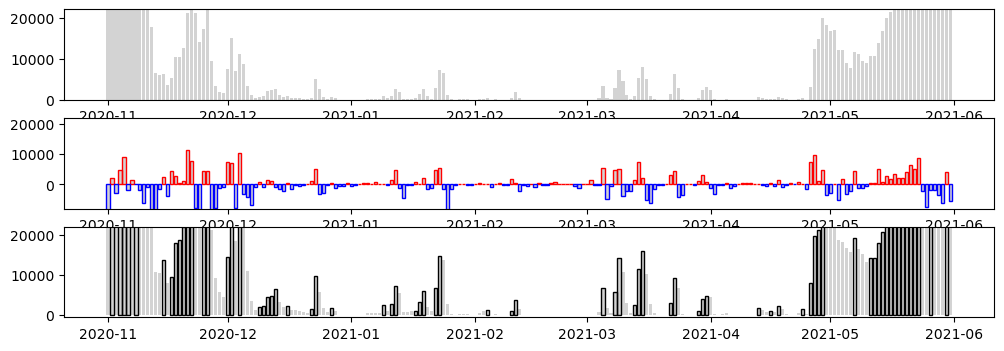

In [13]:
fig, axs = plt.subplots(3,1, figsize=(12,4))

axs[0].bar(dates, oa_abv20, color='lightgray')
axs[0].set_ylim(-10,22000)

axs[1].bar(dates, doa, color='lightgray')
axs[1].bar(dates[doa>0], doa[doa>0], facecolor='none', edgecolor='red')
axs[1].bar(dates[doa<=0], doa[doa<=0], facecolor='none', edgecolor='blue')
axs[1].set_ylim(-8000,22000)


cond = (np.diff(N_abv20)>0)&(N_abv20[1:]>1000)
plt.bar(dates, N_abv20, color='lightgray')
axs[2].bar(dates[1:][cond], N_abv20[1:][cond], facecolor='none', edgecolor='k')
# axs[2].bar(dates, N_abv20, color='r', alpha=0.5)
axs[2].set_ylim(-500,22000)


# Save data

In [14]:
# OUTPUT_FILE = './data/SBS_open_area.nc'


# ds = xr.Dataset(
#         data_vars=dict(
#             doa=(["time"], doa, {"long_name": "daily change in net open water area", "units": "km^2"}),
#             oa = (["time"], oa, {"long_name": "net open water area", "units": "km^2"}),
#             noa_inc = (["time"], opinga_inc, {"long_name": "net new open water area of cells with increase open area", "units": "km^2"}),
#             noa_inc_g20 = (["time"], opinga_inc20, {"long_name": "net new open water area of cells with daily increased OWC >= 20%", "units": "km^2"}),
#             oa_inc_g20 = (["time"], oa_inc20, {"long_name": "net open water area of cells with daily increased OWC >= 20%", "units": "km^2"}),
            
#             N_oa_g20 = (["time"], N_abv20, {"long_name": "# of 1 km^2 cells with OWC >= 20%", "units": "km^2"}),
#             oa_g20 = (["time"], oa_abv20, {"long_name": "net open water area of cells each with OWC >= 20%", "units": "km^2"})
            
#         ),
#         coords=dict(time = (["time"], dates)),
#         attrs=dict(description="open area in coastal polygon"),
#     )

# ds.oa_g20.plot()


# ds.to_netcdf(path=OUTPUT_FILE, 
#              mode='w', format="NETCDF4")    